In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import geocoder
import requests
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Data Preparation

In [6]:
data = pd.read_csv('reisezeit_miv_2011.csv', encoding = 'ISO-8859-1')
data.drop(['GEM_NO', 'PLZ', 'STAND'], axis = 1, inplace = True)
data.at[159, 'NAME'] = 'Aesch (ZH)'  
data.at[675, 'NAME'] = 'Willisau'
data.at[1082, 'NAME'] = 'Erlinsbach (SO)'
data.at[1277:1302, 'KT_KZ'] = 'Appenzell'
data.at[1489, 'NAME'] = 'Donat'
data.at[1564, 'NAME'] = 'St. Antönien'
data.at[1680, 'KT_KZ'] = 'None'

data.head()

,NAME,KT_KZ,REISEZEIT
0,Aeugst am Albis,ZH,18
1,Affoltern am Albis,ZH,15
2,Bonstetten,ZH,14
3,Hausen am Albis,ZH,17
4,Hedingen,ZH,12


The original data set is available at https://opendata.swiss/en/dataset/reisezeit-zu-zentren-mit-dem-miv. This data set contained an xls file (as part of a more general shapefile), that we converted into a csv file. The data contains only the name of the commune and the time to the closest city centre (and originally the district and the commune number, but thex did not seem really useful for us). Of course, we will need to complete the data set to have relevant data to make machine learning models out of it. The first thing we do is getting the coordinates of each village.


We needed to clean the data in order to get the coordinates for some villages. Either, it had a change of name, like for Aesch. Sometimes, the commune was separated in two (like Willisau, that had two communes : Willisau Stadt and Willisau Land).    We also had an issue with the name of the canton : OSM does not seem to understand the abreviation AR, so we replaced it by Appenzell.

Note that we had other problematic communes, but in a later step, we had to delete those anyway, because we could not get the features of these communes. The reason behind is that smaller communes fusioned since this data set was made. Hence, the following code will not compile in its actual form (initially, we did the data cleaning above with more data points).

In [44]:
lat = []
long = []
for i in range(data['NAME'].count()):
    g = geocoder.osm('{}, {}, Switzerland'.format(data['NAME'][i], data['KT_KZ'][i]))
    lat.append(g.osm['y'])
    long.append(g.osm['x'])       

data['Latitude'] = lat
data['Longitude'] = long

We use the geocoder package to get the coordinates of the communes (we had to install the geocoder package in addition to the exts-aml2 environment). It takes the informations of openstreetmaps.org. This loop is however expensive computationally, so we saved the latitude and longitude informations into a new data frame (using .to_csv).

In [98]:
dist_to_zh = []
dist_to_ge = []
dist_to_bs = []
dist_to_ls = []
dist_to_be = []
dist_to_lg = []

for i in range(data['NAME'].count()):
    coord = (data['Latitude'][i], data['Longitude'][i])
    dist_to_zh.append(geopy.distance.vincenty(coord, (data['Latitude'][170], data['Longitude'][170])).km)
    dist_to_ge.append(geopy.distance.vincenty(coord, (data['Latitude'][2788], data['Longitude'][2788])).km)
    dist_to_bs.append(geopy.distance.vincenty(coord, (data['Latitude'][1154], data['Longitude'][1154])).km)
    dist_to_ls.append(geopy.distance.vincenty(coord, (data['Latitude'][2293], data['Longitude'][2293])).km)
    dist_to_be.append(geopy.distance.vincenty(coord, (data['Latitude'][208], data['Longitude'][208])).km)
    dist_to_lg.append(geopy.distance.vincenty(coord, (data['Latitude'][2063], data['Longitude'][2063])).km)

minimal_distance = np.asarray([dist_to_zh, dist_to_ge, dist_to_bs, dist_to_ls, dist_to_be, dist_to_lg]).min(0)
data['Distance to Zürich'] = dist_to_zh
data['Distance to Geneva'] = dist_to_ge
data['Distance to Basel'] = dist_to_bs
data['Distance to Lausanne'] = dist_to_ls
data['Distance to Bern'] = dist_to_be
data['Distance to Lugano'] = dist_to_lg
data['Distance to the next city centre'] = minimal_distance

This algorithm computes the distance of each village to the big cities based on its coordinates. It uses the Vincenty formulas, that can compute the distances between two points of an ellipsoid.

In [ ]:
elevations = []

def get_elevation(lat, long):
    query = ('https://api.open-elevation.com/api/v1/lookup'f'?locations={lat},{long}')
    r = requests.get(query).json() 
    elevation = pd.io.json.json_normalize(r, 'results')['elevation'].values[0]
    return elevation
# Credits to IainD for that function (https://stackoverflow.com/questions/19513212/)

for i in range(data['NAME'].count()):
    elevations.append(get_elevation(data['Latitude'][i], data['Longitude'][i]))

This function gives the elevation of each village, based on its coordinates.

In [3]:
data = pd.read_csv('reisezeiten_complete.csv')
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

We saved the resulting data frame (using .to_csv) and will load the data set above (because getting the coordinates and the altitudes takes a very long time). This gives us the first data frame, containing the different travelling times and all the geographical data relevant for our purposes. We complete now the data set with relevant data of the communes.

In [4]:
data2 = pd.read_excel('cc-d-00.01.02.xls')
data2.drop(['Regionalporträts: Gemeinden - Kennzahlen'], axis = 1, inplace = True)
data2.columns = data2.iloc[4].values
data2.drop(data2.index[0:8], axis = 0, inplace = True)
data2.drop(data2.index[2495:], axis = 0, inplace = True)
data2.drop(data2.columns[-11:], axis = 1, inplace = True)
data2.drop(['Protestantisch', 'Römisch-katolisch', 'keine Zugehörigkeit'], axis = 1, inplace = True)
data2.rename(columns = {'Gemeindename' : 'NAME' }, inplace = True)
data2.dropna(inplace = True)

We use a data set, containing the different statistical informations of the communes. Since the original data set contains the names of the communes as of 2000, we tried to use the oldest available informations (in our case 2012). The reason is that there have been many fusions of communes and we wanted to have as many informations for the communes as possible. 

The data set is an excel file, available on https://opendata.swiss/dataset/regionalportrats-2012-kennzahlen-aller-gemeinden.

We needed to clean the data a bit, because some features did not seem relevant for our purposes, like the political party percentages and the religion appartenances. The other statistics can give a hint if the commune lies in an urban or rural region, so we decided to keep them, even though they are not directly related to what we are interested in. 

We additionally had to drop two communes (Etzelkofen and Hérémence) because they contained null values.

In [5]:
df = pd.merge(data, data2)

We made an inner joint to merge the two data frames to get the relevant features. Note that we lost about 400 data points in the process. For our basic model, that uses only the distances to the next bigger city, we will still use the original data set with its coordinates.

# Data Analysis

We take now a look at the data and what we can observe. First, we see that the coordinates of most communes are correct.

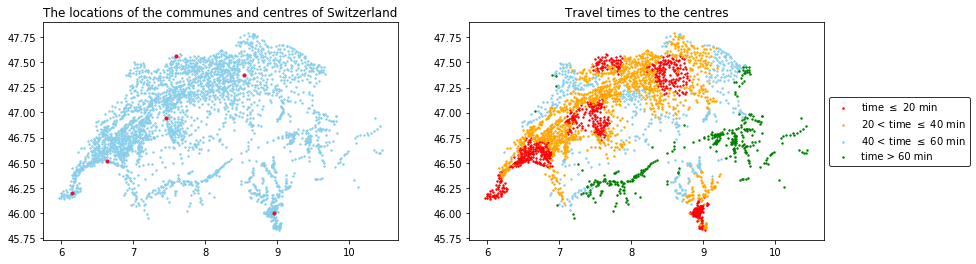

In [292]:
cities = [170, 2788, 1154, 2293, 208, 2063]
filter = data['REISEZEIT'] <= 20
data_close = data[filter]
filter = (data['REISEZEIT'] > 20) & (data['REISEZEIT'] <= 40)
data_med = data[filter]
filter = (data['REISEZEIT'] > 40) & (data['REISEZEIT'] <= 60)
data_medium = data[filter]
filter = data['REISEZEIT'] > 60
data_far = data[filter]

fig, ax = plt.subplots(1, 2, figsize = (14,4))
ax[0].scatter(data['Longitude'], data['Latitude'], s = 2, color = 'skyblue')
ax[0].scatter(data['Longitude'][cities], data['Latitude'][cities], s = 10, color = 'crimson')
ax[0].set_title('The locations of the communes and centres of Switzerland')
ax[1].scatter(data_close['Longitude'], data_close['Latitude'], s = 2, color = 'red', label = 'time $\leq$ 20 min')
ax[1].scatter(data_med['Longitude'], data_med['Latitude'], s = 2, color = 'orange', label = '20 < time $\leq$ 40 min')
ax[1].scatter(data_medium['Longitude'], data_medium['Latitude'], s = 2, color = 'skyblue', label = '40 < time $\leq$ 60 min')
ax[1].scatter(data_far['Longitude'], data_far['Latitude'], s = 2, color = 'green', label = 'time > 60 min')
ax[1].set_title('Travel times to the centres')
ax[1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5), edgecolor = 'black')
plt.show()

The plot on the right-hand side gives us a good visualisation of the data. It shows how far it takes form each commune to its closest city. Of course, the areas close to the cities are closer. Note also that the regions in the mountains and valleys take a longer time to go to the cities. 

The travel times are in our experience very optimistic. Generally, it takes longer to go to the cities from many locations than indicated in the data set. The original model probably does not take in account the traffic, but only (or mostly) the distances on the road and maybe its speed limitations.

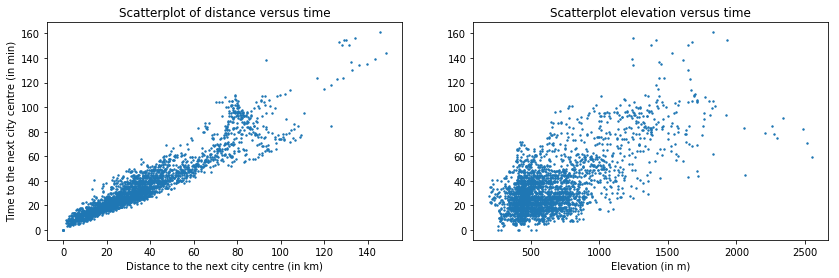

In [66]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].scatter(data['Distance to the next city centre'], data['REISEZEIT'], s = 2)
ax[1].scatter(data['Elevation'], data['REISEZEIT'], s = 2)
ax[0].set_xlabel('Distance to the next city centre (in km)')
ax[0].set_ylabel('Time to the next city centre (in min)')
ax[0].set_title('Scatterplot of distance versus time')
ax[1].set_xlabel('Elevation (in m)')
ax[1].set_title('Scatterplot elevation versus time')
plt.show()

Without surprise, the time to the next city centre with private transportation is heavily correlated with its distance and follows a relatively linear relationship. Note that there may be some outliers. More interesting is to see the relationship with the other parameters.

Taking a look at the smaller extreme values, we find villages like St. Gingolph, that is relatively close to Lausanne as the crow flies, but is located at the other side of a lake, so that it takes a longer time to go there. Note that most of the outliers in the first plot are located in deep valleys. We will analyse more in detail after the following plots.

The outliers in the second scattter plot are more problematic. In fact, there are only very few villages located above 2000 m in Switzerland. For many of the problematic values, the name of the commune is either a portmanteau with the names of two villages, like Klosters-Serneus or communes without a clear centre, like Bagnes. In both cases, openstreetmaps seems to give the coordinates of the barycentre of the commune surface, instead of the coordinates of the main village (in these cases Klosters and Verbier). Hence, for these mountain communes, the barycentre is sometimes located far higher in the mountains and thus gives such high elevation values. We definitely should deal with these false elevations (the distance values will be incorrect as well, but will still be very similar to the correct values) when trying to make predictions.

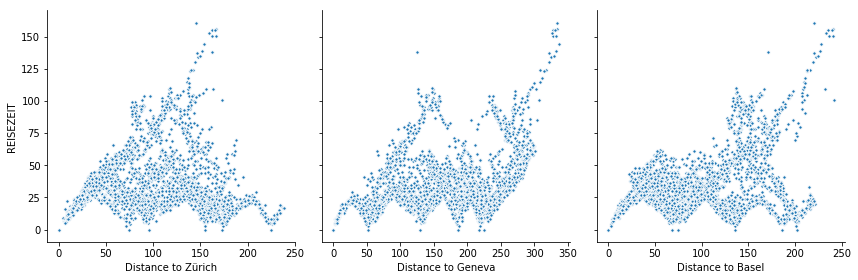

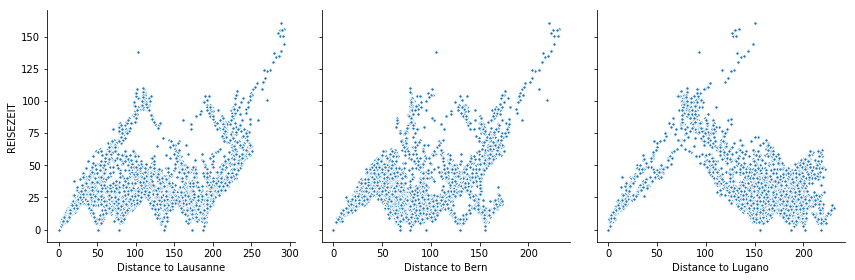

In [124]:
sns.pairplot(data, y_vars = 'REISEZEIT', x_vars = data.columns[5:8], plot_kws = {'s': 12}, size = 4)
sns.pairplot(data, y_vars = 'REISEZEIT', x_vars = data.columns[8:11], plot_kws = {'s': 12}, size = 4)
plt.show()

We found those plots quite interesting, particularly the one of Lugano, showing that the travel time augments with the distance and then diminishes again, because then an other city becomes closer. We also see that the travel time generally augments with the elevation. One reason is that it takes longer to drive the slopes to get to such a village. But also, generally the villages with a higher elevation are generally situated further to the city centres, like in Graubünden and Wallis.

Taking a look at the data set indeed shows that the village the furthest away of a city centre is Samnaun, followed by Müstair, that are both located in a side valley in the far east of Switzerland, close to the Austrian and Italian boarder respectively. Other villages, that are far away from the city centres are located in Wallis, particularly Zermatt, that has the additional feature that it is car-free.

Note that these villages have generally a high elevation and are located far away of the city centres. However, the highest villages of Switzerland are located around St. Moritz, that is not so far away from Lugano (passing through Italy) and have thus a lower travel time than the ones located this valley downwards.

Another interesting graph is the 'Distance to Geneva' graph. Since Geneva is located at the west boarder of Switzerland, it indicates in some way how far east or west the villages are located in Switzerland. Note that there is a peak (with outlier Zermatt) located at around 120 km. These villages probably correspond to the villages of Wallis, that are far away from the cities, because they are located in a valley. The second peak corresponds to the villages of Graubünden, showing without surprise that these villages are generally the furthest away of the centres.

In [5]:
filter = data['Elevation'] > 1900
data = data[~filter]

We did not want to drop the values using z-values, because it would drop many interesting communes (like Zermatt or St. Moritz). Doing it this way drops 12 communes, but only three of them are really located above 1900 m (and two of these have fusioned since then). We can also represent the elevation of the different communes and compare it to the travel times plot.

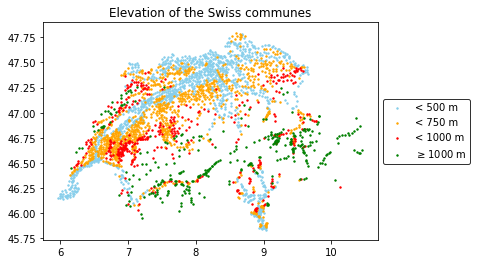

In [14]:
filter = data['Elevation'] < 500
data_low = data[filter]
filter = (data['Elevation'] >= 500) & (data['Elevation'] < 750)
data_med = data[filter]
filter = (data['Elevation'] >= 750) & (data['Elevation'] < 1000)
data_high = data[filter]
filter = data['Elevation'] >= 1000
data_mount = data[filter]

plt.scatter(data_low['Longitude'], data_low['Latitude'], s = 2, color = 'skyblue', label = '< 500 m')
plt.scatter(data_med['Longitude'], data_med['Latitude'], s = 2, color = 'orange', label = '< 750 m')
plt.scatter(data_high['Longitude'], data_high['Latitude'], s = 2, color = 'red', label = '< 1000 m')
plt.scatter(data_mount['Longitude'], data_mount['Latitude'], s = 2, color = 'green', label = '$\geq $1000 m')
plt.title('Elevation of the Swiss communes')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), edgecolor = 'black')
plt.show()

We represented also the communes of Switzerland in fonction of its altitude. This is coherent with the general idea that the communes located higher are further away of the cities based on its transportation times. We could do similar graphics for the other features, but those will probably be chaotic and are generally already done by the Federal Office of Statistics.

In [98]:
log_inh = []
log_surf = []
for i in range(df['NAME'].count()):
    log_inh.append(np.log10(df['Einwohner 1)'][i]))
    log_surf.append(np.log10(df['Gesamtfläche in km² 4)'][i]))

df['LogInhabitants'] = log_inh
df['LogSurface'] = log_surf

When dealing with the additional commune features, we took the logarithm (in base 10) to avoid skewed distributions (the number of inhabitants one was particularily skewed).

# Basic Models

We first make a model, taking in account only the location of the map (i.e. its coordinates). We use a 70-30 split, the train set has around 2000 data points.

In [368]:
data_tr, data_te = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 0)

X_tr_tri = data_tr.iloc[:, 3:5].values
X_te_tri = data_te.iloc[:, 3:5].values
y_tr = data_tr['REISEZEIT'].values
y_te = data_te['REISEZEIT'].values

lr = LinearRegression()
lr.fit(X_tr_tri, y_tr)
y_lr_tri = lr.predict(X_te_tri)

RMSE_tri = np.sqrt(mse(y_te, y_lr_tri))
print('Root Mean Squared Error of our trivial model: ', RMSE_tri)
MAE_tri = mae(y_te, y_lr_tri)
print('Mean Absolute Error of our trivial model: ', MAE_tri)

Root Mean Squared Error of our trivial model:  19.02160058857793
Mean Absolute Error of our trivial model:  14.028757690292597


This gives us a first indication of what we may expect. We now refine the model, adding all the distance informations and the altitudes. We avoided using polynomial features, because all the distances already are provided by the coordinates, so we avoided putting a bigger emphasis on them, even though they are the most important features in our machnine learning model.

In [367]:
X_tr_bas = data_tr.iloc[:, 3:].values
X_te_bas = data_te.iloc[:, 3:].values

lr = LinearRegression()
lr.fit(X_tr_bas, y_tr)
y_lr_bas = lr.predict(X_te_bas)

RMSE_bas = np.sqrt(mse(y_te, y_lr_bas))
print('Root Mean Squared Error of our basic model (linear regression): ', RMSE_bas)
MAE_bas = mae(y_te, y_lr_bas)
print('Mean Absolute Error of our basic model (linear regression): ', MAE_bas)

Root Mean Squared Error of our basic model (linear regression):  6.343915773296437
Mean Absolute Error of our basic model (linear regression):  4.565919143076437


We see already that the additional features already improve significantly the precision of the model. Here, we used a linear regression. We tried using a Ridge Regression as well, but it did not improve our model. The errors remained very similar, even after a grid search.

In [408]:
pipe_knn =  Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 5))])
pipe_knn.fit(X_tr_bas, y_tr)
y_knn_bas = pipe_knn.predict(X_te_bas)

RMSE_knn = np.sqrt(mse(y_te, y_knn_bas))
print('Root Mean Squared Error of our basic model (knn): ', RMSE_knn)
MAE_knn = mae(y_te, y_knn_bas)
print('Mean Absolute Error of our basic model (knn): ', MAE_knn)

Root Mean Squared Error of our basic model (knn):  5.92232243315994
Mean Absolute Error of our basic model (knn):  4.094688221709007


We tried using the k-nearest neighbors algorithm as well. We had the reasoning that such a model would be quite relevant to such a problem, because the neighbor communes would influence greatly the travel time of this commune as well. Indeed, this gives a very low error and in fact, the error will be even better if we put $k=1$. However, we realised after that it is a bit like cheating. If we assign to each village of the test set, the values of the nearest village of the train set, the accuracy of the model will be quite high. But, we did not create a new machine learning model, but in some way copied the results of the already existing model. When adding the demographic features in the next section, this model did not perform well.

# Complex Model

We are interested now if adding the additional features, most of them about the population of the communes, will get us better or worse results than only the geographical features. We had the reasoning that some of these features could influence the travel time. For example, towns are generally better connected to the highways than random villages, so we may assume that it is thus faster to travel to the big cities. Even if the greatest factor will still be the geographical features. The area of the commune and its density could give us another indication if the commune is urban or rural, because communes with a big surface (cities excepted) generally lie in the mountains and are therefore less connected to the rest. 

On the other hand, we lost some data in the process, due to the fusions of many communes. Hence, we initally did not know if it will give a better or a worse accuracy to the model.

In [16]:
df_tr, df_te = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 0)

X_tr_comp = df_tr.drop(['NAME', 'KT_KZ', 'Einwohner 1)', 'Gesamtfläche in km² 4)', 'REISEZEIT'], axis = 1).values
X_te_comp = df_te.drop(['NAME', 'KT_KZ', 'Einwohner 1)', 'Gesamtfläche in km² 4)', 'REISEZEIT'], axis = 1).values
y_tr_comp = df_tr['REISEZEIT'].values
y_te_comp = df_te['REISEZEIT'].values

ridge = Ridge(alpha = 1)
ridge.fit(X_tr_comp, y_tr_comp)
y_ridge_comp = ridge.predict(X_te_comp)

RMSE_comp = np.sqrt(mse(y_te_comp, y_ridge_comp))
print('Root Mean Squared Error of our complex model: ', RMSE_comp)
MAE_comp = mae(y_te_comp, y_ridge_comp)
print('Mean Absolute Error of our complex model: ', MAE_comp)

Root Mean Squared Error of our complex model:  5.643607591115169
Mean Absolute Error of our complex model:  4.098964840996833


In this case, a ridge regression gives slightly better results than a linear regression. We note that we have a significant improvement of our results compared to our basic model. The additional informations gave more informations on the data points and the machine learning model became better, similarily to the one of the third project. However, in our case, the two models did not have the same amount of data points and this also may have influenced the better error term. Note that our model is still heavily influenced by the coordinates features, because we constructed the distance table out of this information. If we would not have done that, our results will probably be significantly worse.

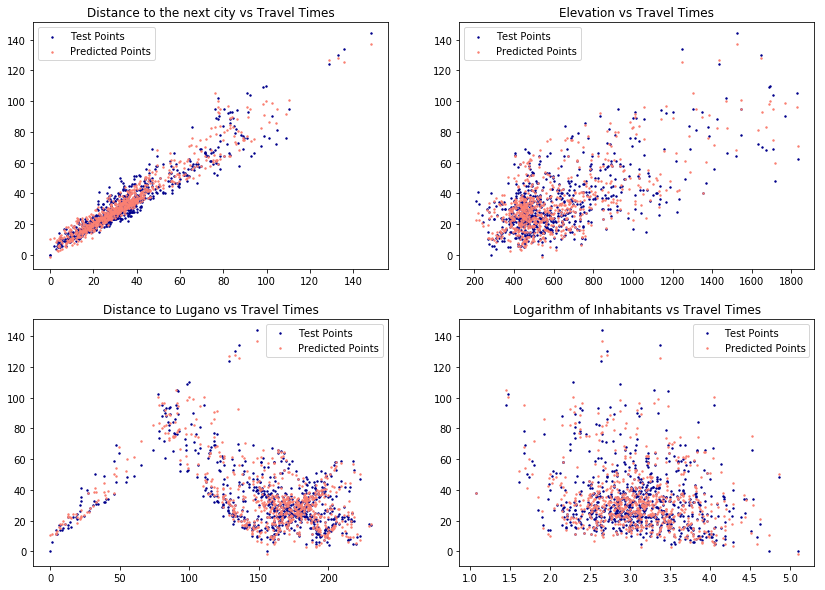

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (14, 10))
ax1[0].scatter(df_te['Distance to the next city centre'], df_te['REISEZEIT'], s = 2, color = 'darkblue', label='Test Points')
ax1[0].scatter(df_te['Distance to the next city centre'], y_ridge_comp, s = 2, color = 'salmon', label = 'Predicted Points')
ax1[1].scatter(df_te['Elevation'], df_te['REISEZEIT'], s = 2, color = 'darkblue', label = 'Test Points')
ax1[1].scatter(df_te['Elevation'], y_ridge_comp, s = 2, color = 'salmon', label = 'Predicted Points')
ax2[0].scatter(df_te['Distance to Lugano'], df_te['REISEZEIT'], s = 2, color = 'darkblue', label = 'Test Points')
ax2[0].scatter(df_te['Distance to Lugano'], y_ridge_comp, s = 2, color = 'salmon', label = 'Predicted Points')
ax2[1].scatter(df_te['LogInhabitants'], df_te['REISEZEIT'], s = 2, color = 'darkblue', label = 'Test Points')
ax2[1].scatter(df_te['LogInhabitants'], y_ridge_comp, s = 2, color = 'salmon', label = 'Predicted Points')
ax1[0].legend(), ax1[1].legend(), ax2[0].legend(), ax2[1].legend()
ax1[0].set_title('Distance to the next city vs Travel Times')
ax1[1].set_title('Elevation vs Travel Times')
ax2[0].set_title('Distance to Lugano vs Travel Times')
ax2[1].set_title('Logarithm of Inhabitants vs Travel Times')
plt.show()

We compared the test points of our complete data frame to the points predicted by our complex machine learning model. The first plot shows the distance to the nearest city centre and the travel times. We see that it has difficulties to assign the correct value to the extreme points. The distribution of the points close to a city is relatively linear, whereas the test points have a bigger variance. 

Concerning the other plots, the distribution of the predicted points seems to be quite similar to the test points.

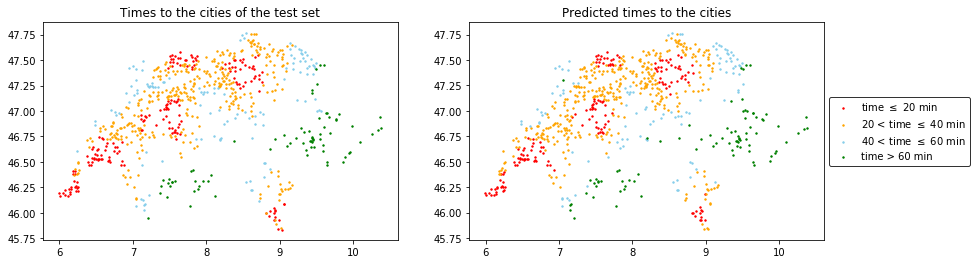

In [17]:
df_te = df_te.assign(Predictions = y_ridge_comp)

filter = df_te['REISEZEIT'] <= 20
df_close = df_te[filter]
filter = (df_te['REISEZEIT'] > 20) & (df_te['REISEZEIT'] <= 40)
df_med = df_te[filter]
filter = (df_te['REISEZEIT'] > 40) & (df_te['REISEZEIT'] <= 60)
df_medium = df_te[filter]
filter = df_te['REISEZEIT'] > 60
df_far = df_te[filter]

filter = df_te['Predictions'] <= 20
df2_close = df_te[filter]
filter = (df_te['Predictions'] > 20) & (df_te['Predictions'] <= 40)
df2_med = df_te[filter]
filter = (df_te['Predictions'] > 40) & (df_te['Predictions'] <= 60)
df2_medium = df_te[filter]
filter = df_te['Predictions'] > 60
df2_far = df_te[filter]

fig, ax = plt.subplots(1, 2, figsize = (14,4))
ax[0].scatter(df_close['Longitude'], df_close['Latitude'], s = 2, color = 'red', label = 'time $\leq$ 20 min')
ax[0].scatter(df_med['Longitude'], df_med['Latitude'], s = 2, color = 'orange', label = '20 < time $\leq$ 40 min')
ax[0].scatter(df_medium['Longitude'], df_medium['Latitude'], s = 2, color = 'skyblue', label = '40 < time $\leq$ 60 min')
ax[0].scatter(df_far['Longitude'], df_far['Latitude'], s = 2, color = 'green', label = 'time > 60 min')
ax[1].scatter(df2_close['Longitude'], df2_close['Latitude'], s = 2, color = 'red', label = 'time $\leq$ 20 min')
ax[1].scatter(df2_med['Longitude'], df2_med['Latitude'], s = 2, color = 'orange', label = '20 < time $\leq$ 40 min')
ax[1].scatter(df2_medium['Longitude'], df2_medium['Latitude'], s = 2, color = 'skyblue', label = '40 < time $\leq$ 60 min')
ax[1].scatter(df2_far['Longitude'], df2_far['Latitude'], s = 2, color = 'green', label = 'time > 60 min')
ax[1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5), edgecolor = 'black')
ax[0].set_title('Times to the cities of the test set')
ax[1].set_title('Predicted times to the cities')
plt.show()

If looking attentively, we some differences between the two plots. However, the machine learning model is able to get quite similar results. We can make an interesting observation in the north-east of Switzerland, where many points are of different colors. Close to the Lichtenstein boarder, the machine learning model assigns a travel time superior of one hour to many communes, whereas the original data does not. However, for two communes situated north of that group it is the opposite. These two villages are geographically closer to Zürich and are located at similar altitudes, so it assumes that they are closer to Zürich than the villages south. However, on the west of these villages lies the Säntis massif, so it takes longer to go there. That is the disadvantage of this model, it does not know the topographical informations of Switzerland and it would be difficult to implement it.

In general, the machine learning model seems to assign higher travel times than the original data. As already said, the given data seems to be quite optimistic in our opinion and we suppose it is based on the road kilometres between the commune and its closest city. Taking in account the altitude and many demographic features, able to distinguish between urban and rural regions may give a more appropriate model. 

If we want to make an even better and more realistic model, we should take in account the road kilometres, the type of road that leads to the city centre, traffic data, topographical data and so on. These datas will of course be much more relevant than the demographical we used here. However, getting this data should me more complicated and the traffic data may not exist at all. These objectives are probably outside the scope of this project. 

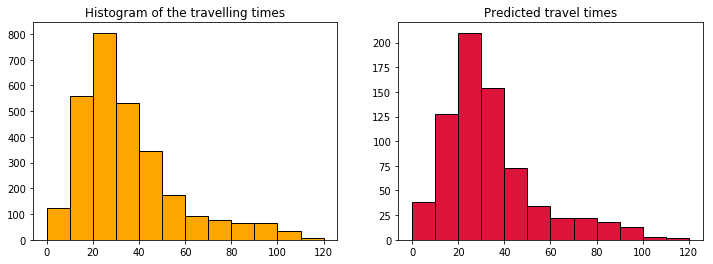

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(data['REISEZEIT'], bins = 10 * np.arange(13), color = 'orange', edgecolor = 'black')
ax[1].hist(df_te['Predictions'], bins = 10 * np.arange(13), color = 'crimson', edgecolor = 'black')
ax[0].set_title('Histogram of the travelling times')
ax[1].set_title('Predicted travel times')
plt.show()

We compared the histogram of the travel times of the original data set and the predicted travel times on the test set. We note that the two histograms have a similar shape. As already discussed above, the machine learning model seems to give higher predictions, but it may also be due to the distribution of the separation of the data into train and test set. Using the test data frame with the demographic features gives indeed an even more similar histogram. 

In [43]:
df_te['Predictions'].describe()

count    721.000000
mean      34.288522
std       21.524144
min        0.795733
25%       20.578593
50%       29.410798
75%       40.684246
max      134.014752
Name: Predictions, dtype: float64

In [41]:
data['REISEZEIT'].describe()

count    2896.000000
mean       35.068025
std        22.839741
min         0.000000
25%        20.000000
50%        29.000000
75%        43.000000
max       161.000000
Name: REISEZEIT, dtype: float64

Comparing the distribution gives very similar results between the original data set and our predictions. Note that the machine learning model does not assign the value 0 to the big cities in the test set (Bern and Geneva), but is still able to assign them very small travel times.

# Conclusion

Our machine learning model has been able to give quite satisfacting results. Our complex model using the demographic features seems to be able to give better results, but the fact that the data set is slightly smaller and does not have the same test points may influence the results. Still, the error is significantly smaller, so we think that it is useful to add the demographic features to our model. A mean absolute error of 4 minutes seems to be quite good and the fact that both the histogram and the maps with the travel times are very similar emphasizes the fact that the results are convincing. 

We chose this data set, because it seemed to be an interesting set for doing machine learning. We wanted to use a data set, that is different from the type of data sets that exist on Kaggle or other websites. In fact, the data collecting part was quite interesting, because we had to use some tools not seen in the course. The data set was interesting for doing some analyses. The topography of Switzerland with many mountains and lakes made this problem more complex than for many other countries.  We tried to solve the issues using altitude features. If we wanted to make better predictions, we probably had to do much more geocoding. A more interesting feature would have been the number of kilometres of roads seaprating the commune to the city, but this would have been difficult to implement. Besides, it would have been an overkill, since the travel times of the original data were maybe proportional to this feature. Supplementary informations that are relevant may include the distance to the next highway exit. This would probably be possible to implement using some geocoding, but we feared that this feature would not have the desired importance in the machine learing model.

Another problem we encountered was the fact that the data uses the communes of 2000 and since then many communes of Switzerland fusioned. We wanted to use the statistical informations of 2000, but we were only able to find a pdf file. Hence, we made two models, one using the communes of 2000 and the informations using the coordinates; and another one using the data as of 2012. So we had the problem that many communes, for which we had the travel times could not be completed with demographical data. On the other hand, there were new communes, like Bourg-en-Lavaux that did not have informations on the travel times. For comparing the two models, it was maybe better to use the same data set in both cases. So, comparing the two models may not be objective.

The machine learning model by itself was more straightforward than we initially expected. The model and approach taken were quite similar to the third course projet. But in the actual project, we did not have ordinal and categorical variables. We thought using z-values to deal with outliers, but this would delete many interesting communes in Graubünden and in the mountains. Therefore, the model would fail to determine an accurate travel time for similar communes.  The demographic features did not seem to have outliers besides the commune surface and population. For these, we took the logarithm to avoid distributions that are too skewed. We may have been able to slightly improve the accuracy by considering polynomial features. The coordinates were the most interesting feature in our opinion, so we gave it special importance by making a distance table, instead of using polynomial features. We maybe should have emphasised more the altitude feature that seemed relevant to our eyes. But in some way, this feature is correlated with some features of the commune (for example communes in the mountains have generally a bigger surface and thus a lower density. In addition, its economies specialise in the first sector, have an older population and mainly use private transportation).  Therefore, we avoided using the polynomial features, because choosing which features are more important than others is an arbitrary choice (the coordinates excepted). So even if this part was not very complicated, the coordinates were able to provide some interesting representations. 